<a href="https://colab.research.google.com/github/Redwoods/Py/blob/master/py-ml-dl-tf/Keras/har_keras_cnn1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1-CNN analysis of time series 
> [har-keras-cnn](https://github.com/ni79ls/har-keras-cnn)

In [3]:
# Compatibility layer between Python 2 and Python 3
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
# %% functions


def read_data(file_path):

    """
    This function reads the accelerometer data from a file

    Args:
        file_path: URL pointing to the CSV file

    Returns:
        A pandas dataframe
    """

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df


def show_basic_dataframe_info(dataframe,
                              preview_rows=20):

    """
    This function shows basic information for the given dataframe

    Args:
        dataframe: A Pandas DataFrame expected to contain data
        preview_rows: An integer value of how many rows to preview

    Returns:
        Nothing
    """

    # Shape and how many rows and columns
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))
    print("Number of rows in the dataframe: %i\n" % (dataframe.shape[0]))
    print("First 20 rows of the dataframe:\n")
    # Show first 20 rows
    print(dataframe.head(preview_rows))
    print("\nDescription of dataframe:\n")
    # Describe dataset like mean, min, max, etc.
    # print(dataframe.describe())

    
    
def create_segments_and_labels(df, time_steps, step, label_name):

    """
    This function receives a dataframe and returns the reshaped segments
    of x,y,z acceleration as well as the corresponding labels

    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
    Returns:
        reshaped_segments
        labels:
    """

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

# %%

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


# Not used right now
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma

# def feature_normalize(dataset):

#     mu = np.mean(dataset, axis=0)
#     sigma = np.std(dataset, axis=0)
#     return (dataset - mu)/sigma

def plot_axis(ax, x, y, title):

    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(12, 8),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()


def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()
##

In [5]:
# ------- THE PROGRAM TO LOAD DATA AND TRAIN THE MODEL -------

# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)

keras version  2.2.4


In [0]:
LABELS = ["Downstairs",
          "Jogging",
          "Sitting",
          "Standing",
          "Upstairs",
          "Walking"]
# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

# %%

In [8]:
# Upload data into Google colab cloud
# upload file: WISDM_ar_v1.1_raw.txt
# http://www.cis.fordham.edu/wisdm/dataset.php

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving WISDM_ar_v1.1_raw.txt to WISDM_ar_v1.1_raw.txt
User uploaded file "WISDM_ar_v1.1_raw.txt" with length 50326282 bytes


In [9]:
ls

sample_data/  WISDM_ar_v1.1_raw.txt


In [10]:
print("\n--- Load, inspect and transform data ---\n")

# Load data set containing all the data from csv
df = read_data('WISDM_ar_v1.1_raw.txt')
print(df.shape)
# Describe the data
show_basic_dataframe_info(df, 20)


--- Load, inspect and transform data ---

(1098203, 6)
Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203

First 20 rows of the dataframe:

    user-id activity       timestamp  x-axis  y-axis  z-axis
0        33  Jogging  49105962326000    -0.7    12.7     0.5
1        33  Jogging  49106062271000     5.0    11.3     1.0
2        33  Jogging  49106112167000     4.9    10.9    -0.1
3        33  Jogging  49106222305000    -0.6    18.5     3.0
4        33  Jogging  49106332290000    -1.2    12.1     7.2
5        33  Jogging  49106442306000     1.4    -2.5    -6.5
6        33  Jogging  49106542312000    -0.6    10.6     5.7
7        33  Jogging  49106652389000    -0.5    13.9     7.1
8        33  Jogging  49106762313000    -8.4    11.4     5.1
9        33  Jogging  49106872299000     1.0     1.4     1.6
10       33  Jogging  49106982315000    -8.2    19.6     2.7
11       33  Jogging  49107092330000     1.4     5.8     3.0
12       33  Jogging  49107202316000  

In [11]:
df.size

6589218

In [12]:
np.unique(df['user-id'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

In [13]:
g_id = df.groupby('user-id')
g_id.size()

user-id
1     29978
2     23525
3     35161
4     11371
5     28509
6     29704
7     30967
8     41188
9     12923
10    34883
11    31658
12    32641
13    37093
14    38192
15    28154
16    20470
17    22020
18    32811
19    45383
20    56632
21    35436
22    22310
23    25673
24    25736
25    13468
26    32578
27    34958
28    21358
29    38245
30    25335
31    44282
32    35506
33    29453
34    35947
35    22394
36    32261
dtype: int64

In [14]:
g_id.size()[1],g_id.size()[36]

(29978, 32261)

In [15]:
df['user-id'].value_counts()

20    56632
19    45383
31    44282
8     41188
29    38245
14    38192
13    37093
34    35947
32    35506
21    35436
3     35161
27    34958
10    34883
18    32811
12    32641
26    32578
36    32261
11    31658
7     30967
1     29978
6     29704
33    29453
5     28509
15    28154
24    25736
23    25673
30    25335
2     23525
35    22394
22    22310
17    22020
28    21358
16    20470
25    13468
9     12923
4     11371
Name: user-id, dtype: int64

In [16]:
g_ac = df.groupby('activity')
g_ac.size()

activity
Downstairs    100427
Jogging       342176
Sitting        59939
Standing       48395
Upstairs      122869
Walking       424397
dtype: int64

In [17]:
g_ac.size()['Walking']

424397

In [18]:
df['activity'].value_counts()

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

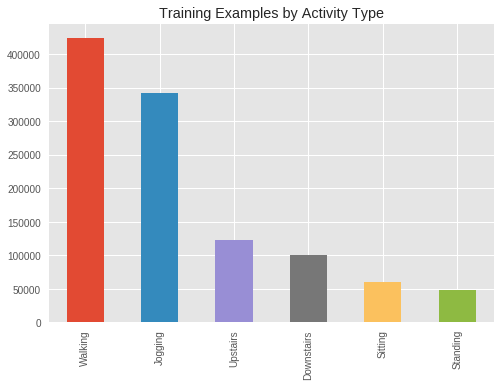

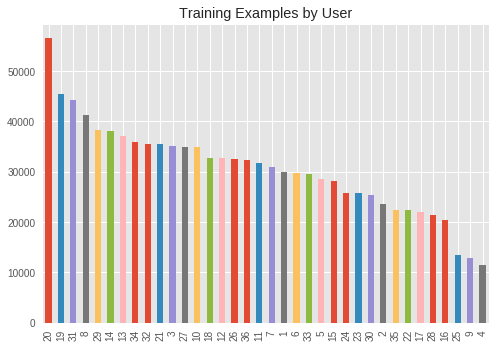

In [19]:
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()

df['user-id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

### Plot graphs of six activities

In [20]:
np.unique(df["activity"])

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

In [21]:
for activity in np.unique(df["activity"]):
    print(activity,' : ',df[df["activity"] == activity].head())

Downstairs  :        user-id    activity       timestamp  x-axis  y-axis  z-axis
1769       33  Downstairs  49646322311000    -0.0     5.0     6.5
1770       33  Downstairs  49646422317000    -0.5     4.4     7.4
1771       33  Downstairs  49646522323000    -0.3     4.6     6.5
1772       33  Downstairs  49646572281000    -0.3     4.5     6.4
1773       33  Downstairs  49646672317000    -1.5     5.2     7.2
Jogging  :     user-id activity       timestamp  x-axis  y-axis  z-axis
0       33  Jogging  49105962326000    -0.7    12.7     0.5
1       33  Jogging  49106062271000     5.0    11.3     1.0
2       33  Jogging  49106112167000     4.9    10.9    -0.1
3       33  Jogging  49106222305000    -0.6    18.5     3.0
4       33  Jogging  49106332290000    -1.2    12.1     7.2
Sitting  :          user-id activity       timestamp  x-axis  y-axis  z-axis
221333       27  Sitting  12363992261000     2.6     9.7     1.0
221334       27  Sitting  12364042279000     2.7     9.5     0.5
221335    

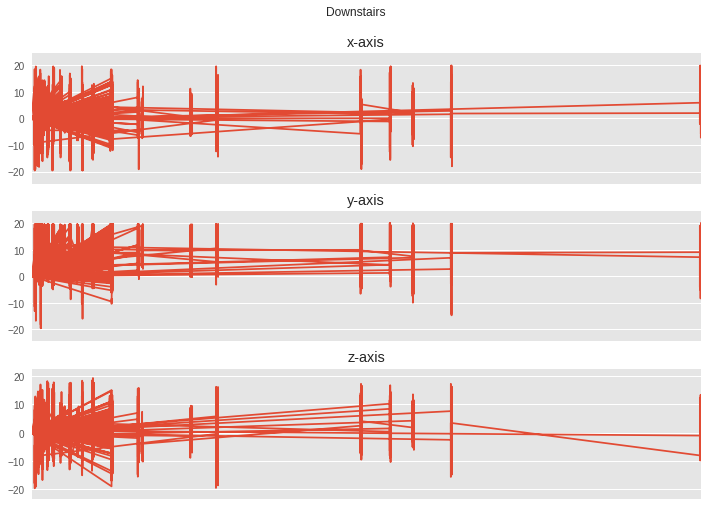

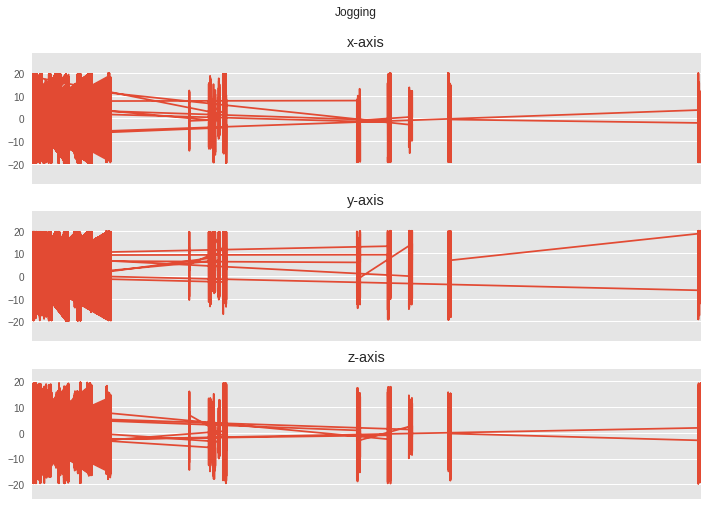

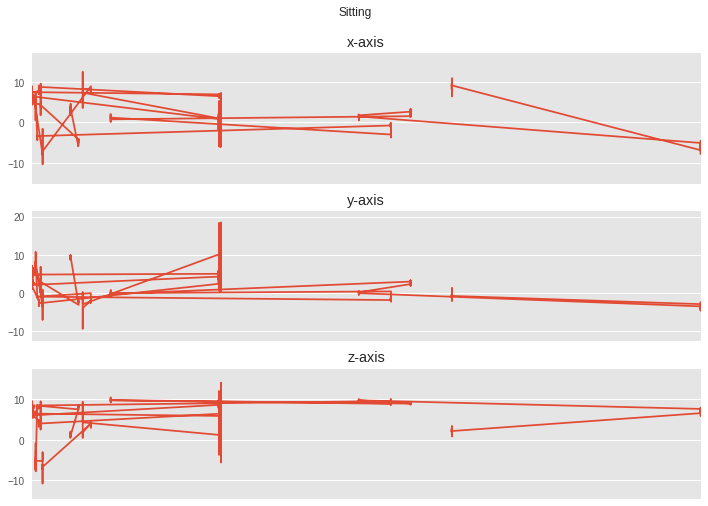

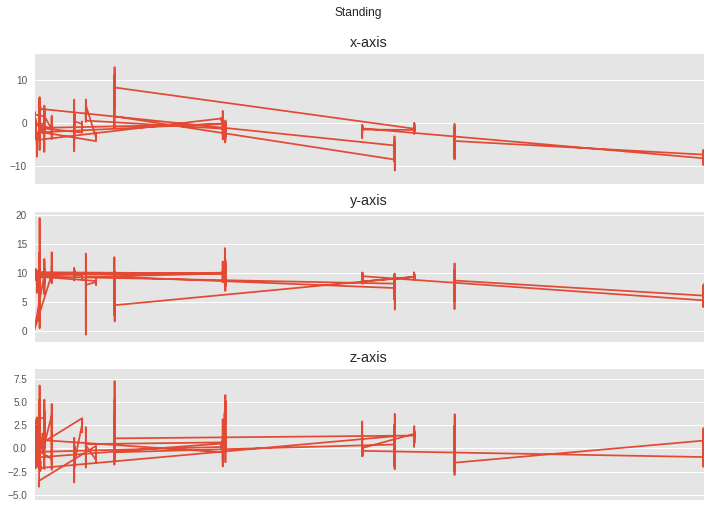

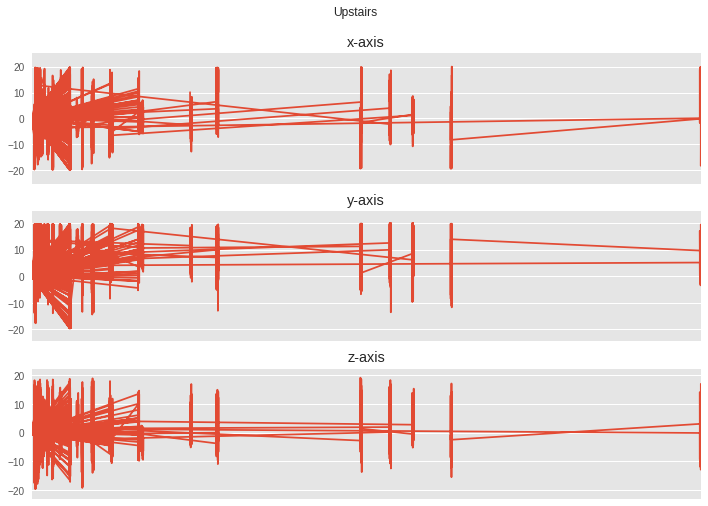

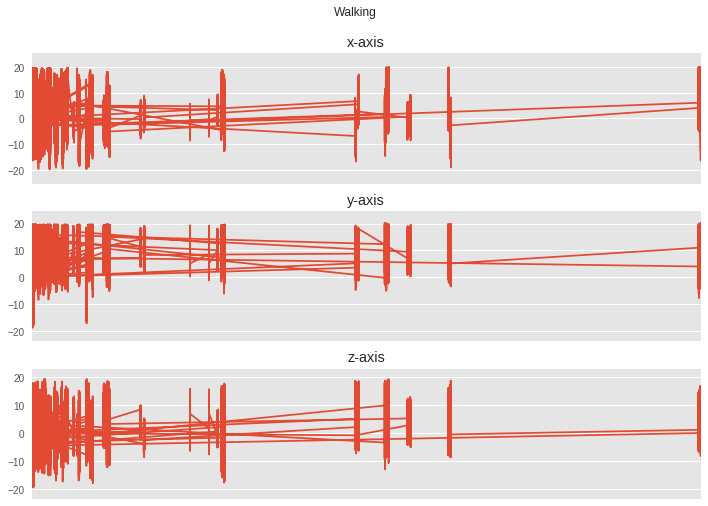

In [22]:
for activity in np.unique(df["activity"]):
    subset = df[df["activity"] == activity][:-1]
    plot_activity(activity, subset)

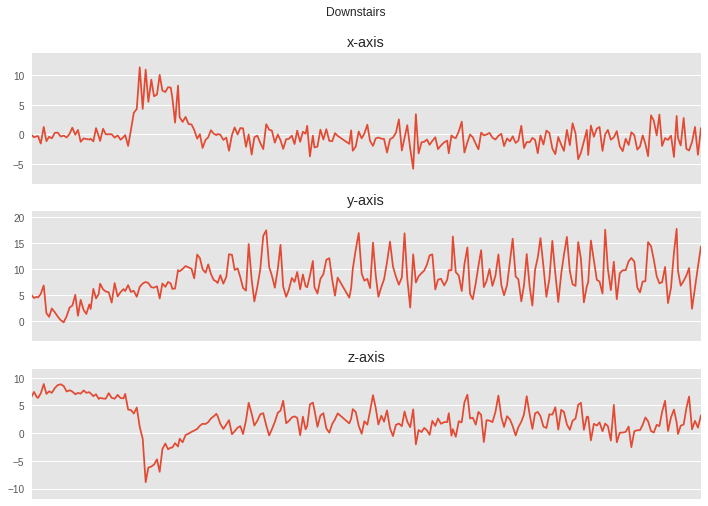

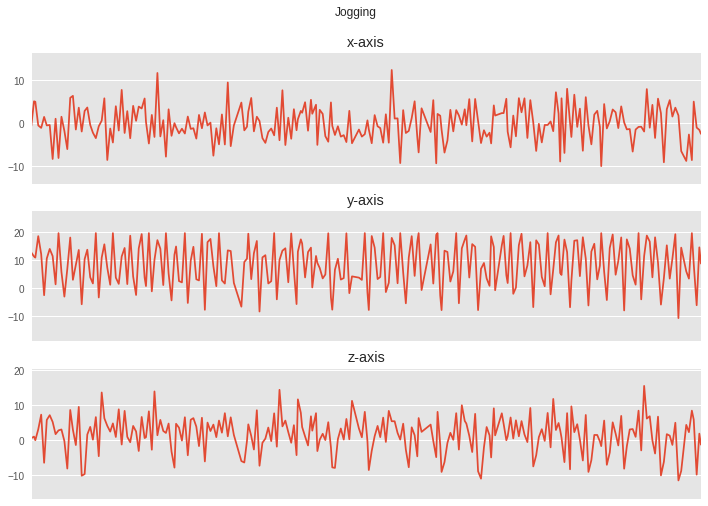

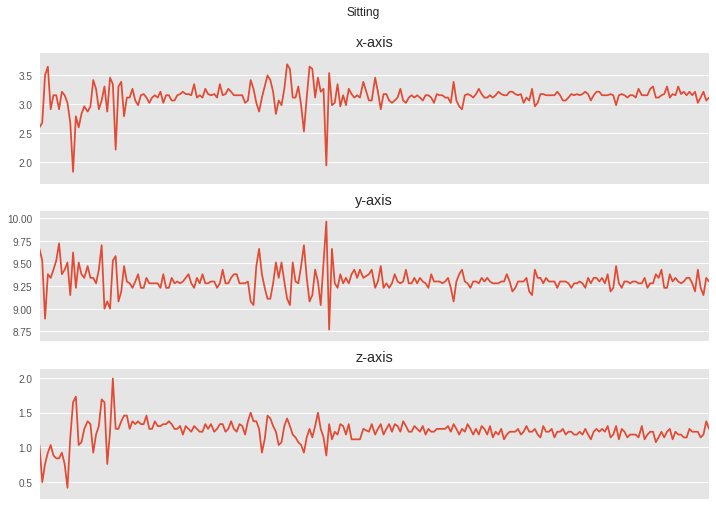

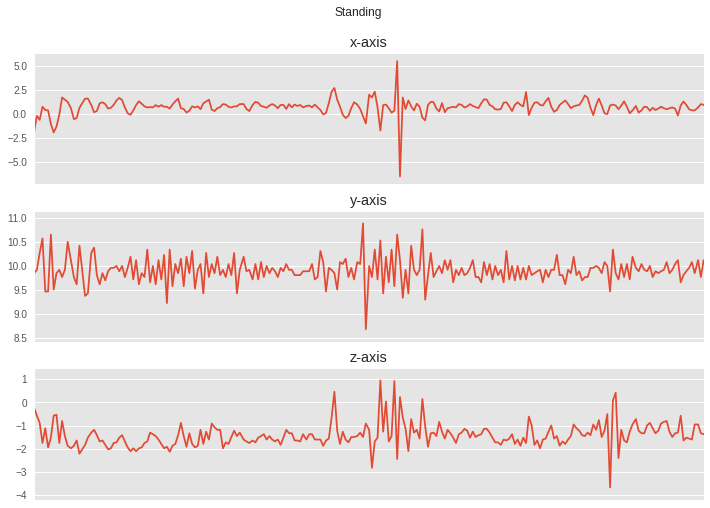

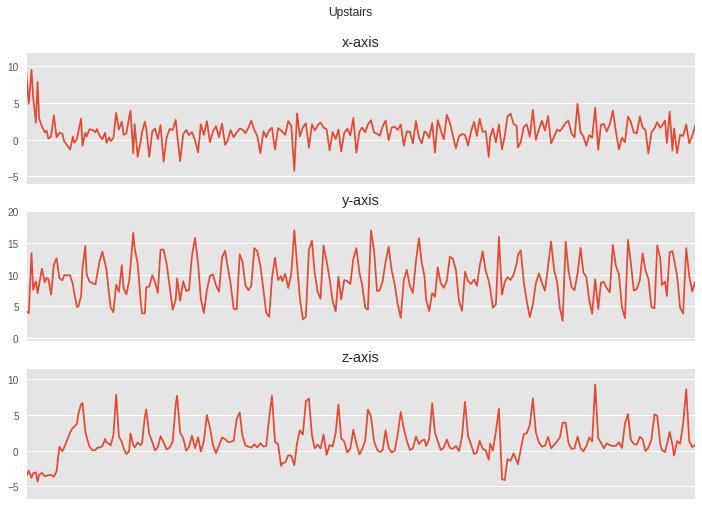

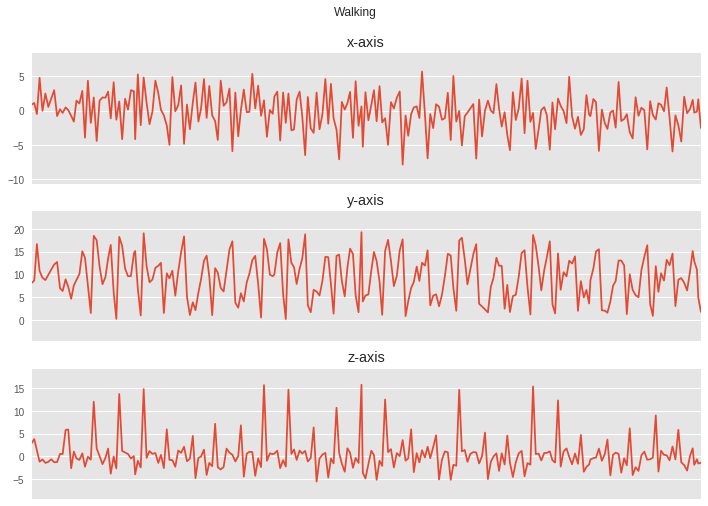

In [23]:
for activity in np.unique(df["activity"]):
    subset = df[df["activity"] == activity][:240]
    plot_activity(activity, subset)

In [24]:
# Define column name of the label vector
LABEL = "ActivityEncoded"
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df["activity"].values.ravel())
df.head()
# %%

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.7,12.7,0.5,1
1,33,Jogging,49106062271000,5.0,11.3,1.0,1
2,33,Jogging,49106112167000,4.9,10.9,-0.1,1
3,33,Jogging,49106222305000,-0.6,18.5,3.0,1
4,33,Jogging,49106332290000,-1.2,12.1,7.2,1


In [25]:
le.classes_, np.unique(df['ActivityEncoded'])

(array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
        'Walking'], dtype=object), array([0, 1, 2, 3, 4, 5]))

***

In [26]:
print("\n--- training and test set ---\n")

# Differentiate between test set and training set
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]


--- training and test set ---



In [27]:
df_train.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
8489,17,Walking,57869902574000,0.6,9.8,-0.5,5
8490,17,Walking,57870012316000,-0.0,10.2,-0.6,5
8491,17,Walking,57870122301000,-0.2,9.8,-0.7,5
8492,17,Walking,57870222246000,0.1,10.1,-0.5,5
8493,17,Walking,57870332292000,0.1,10.1,-0.6,5


In [0]:
# Normalize features for training data set
# dfmi.loc[:,('one','second')] = value
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
df_train['x-axis'] = feature_normalize(df_train['x-axis'])
df_train['y-axis'] = feature_normalize(df_train['y-axis'])
df_train['z-axis'] = feature_normalize(df_train['z-axis'])
# df_train.loc[:,'x-axis'] = feature_normalize(df_train['x-axis'])
# df_train.loc[:,'z-axis'] = feature_normalize(df_train['z-axis'])
# Round in order to comply to NSNumber from iOS
df_train = df_train.round({'x-axis': 6, 'y-axis': 6, 'z-axis': 6})

In [29]:
df_train.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
8489,17,Walking,57869902574000,0.0,0.4,-0.2,5
8490,17,Walking,57870012316000,-0.1,0.4,-0.2,5
8491,17,Walking,57870122301000,-0.1,0.4,-0.2,5
8492,17,Walking,57870222246000,-0.0,0.4,-0.2,5
8493,17,Walking,57870332292000,-0.0,0.4,-0.2,5


In [30]:
df_train.shape

(834780, 7)

In [31]:
print("\n--- Reshape the data into segments ---\n")
# Reshape the training data into segments
# so that they can be processed by the network
x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

# %%


--- Reshape the data into segments ---



In [32]:
print("\n--- Reshape data to be accepted by Keras ---\n")

# Inspect x data
print('x_train shape: ', x_train.shape)
# Displays (20869, 80, 3)
print(x_train.shape[0], 'training samples')
# Displays 20869 train samples

# Inspect y data
print('y_train shape: ', y_train.shape)
# Displays (20869,)


--- Reshape data to be accepted by Keras ---

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)


In [33]:
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [34]:
# Set input_shape / reshape for Keras
# Remark: acceleration data is concatenated in one array in order to feed
# it properly into coreml later, the preferred matrix of shape [40,3]
# cannot be read in with the current version of coreml (see also reshape
# layer as the first layer in the keras model)
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)

print('x_train shape:', x_train.shape)
# x_train shape: (20869, 240)
print('input_shape:', input_shape)
# input_shape: (240)

# Convert type for Keras otherwise Keras cannot process the data
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

x_train shape: (20868, 240)
input_shape: 240


In [35]:
print("\n--- One-hot encoding of y_train labels ---\n")
# One-hot encoding of y_train labels (only execute once!)
y_train = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train.shape)


--- One-hot encoding of y_train labels ---

New y_train shape:  (20868, 6)


In [36]:
y_train[[0,2000,5000,10000,15000,20000,-1]]  # examples of one-hot encoding

array([[0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

### Neural network model - 1d cnn

In [37]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%


--- Create neural network model ---

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 71, 100)           3100      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 62, 100)           100100    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 160)           160160    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2, 160)            256160    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16

In [38]:
print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)


--- Fit the model ---

Train on 16694 samples, validate on 4174 samples
Epoch 1/50
16694/16694 [==============================] - 7s 396us/step - loss: 0.7437 - acc: 0.7245 - val_loss: 0.5878 - val_acc: 0.8091
Epoch 2/50
16694/16694 [==============================] - 1s 76us/step - loss: 0.3710 - acc: 0.8565 - val_loss: 0.5754 - val_acc: 0.8047
Epoch 3/50
16694/16694 [==============================] - 1s 77us/step - loss: 0.2554 - acc: 0.9009 - val_loss: 0.4755 - val_acc: 0.8491
Epoch 4/50
16694/16694 [==============================] - 1s 75us/step - loss: 0.2042 - acc: 0.9302 - val_loss: 0.5739 - val_acc: 0.8155
Epoch 5/50
16694/16694 [==============================] - 1s 75us/step - loss: 0.1748 - acc: 0.9427 - val_loss: 0.5588 - val_acc: 0.8256
Epoch 6/50
16694/16694 [==============================] - 1s 75us/step - loss: 0.1366 - acc: 0.9575 - val_loss: 0.5863 - val_acc: 0.8304
Epoch 7/50
16694/16694 [==============================] - 1s 75us/step - loss: 0.1222 - acc: 0.9596 - va


--- Learning curve of model training ---



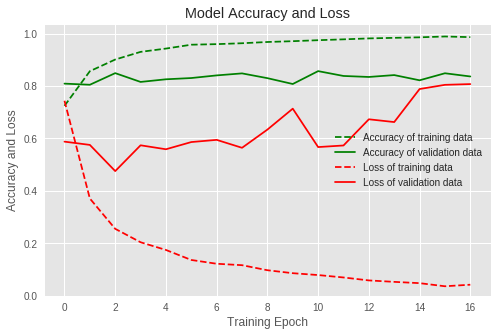

In [39]:
print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['acc'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_acc'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [40]:
print("\n--- Check against test data ---\n")

# Normalize features for test data set
df_test['x-axis'] = feature_normalize(df_test['x-axis'])
df_test['y-axis'] = feature_normalize(df_test['y-axis'])
df_test['z-axis'] = feature_normalize(df_test['z-axis'])

df_test = df_test.round({'x-axis': 6, 'y-axis': 6, 'z-axis': 6})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, num_classes)


--- Check against test data ---



In [41]:
print("\n--- Accuracy on test data---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])


--- Accuracy on test data---

6584/6584 [==============================] - 1s 126us/step

Accuracy on test data: 0.90

Loss on test data: 0.56



--- Confusion matrix for test data ---



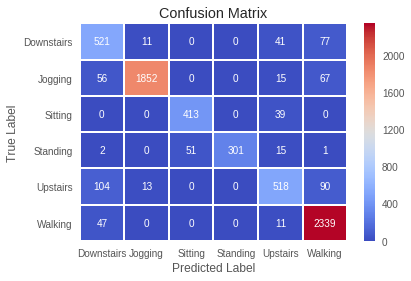

In [42]:
print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

In [43]:
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Classification report for test data ---

             precision    recall  f1-score   support

          0       0.71      0.80      0.76       650
          1       0.99      0.93      0.96      1990
          2       0.89      0.91      0.90       452
          3       1.00      0.81      0.90       370
          4       0.81      0.71      0.76       725
          5       0.91      0.98      0.94      2397

avg / total       0.91      0.90      0.90      6584



***